# Analysis of Real-World Data from a Solar-Equipped Smart Home

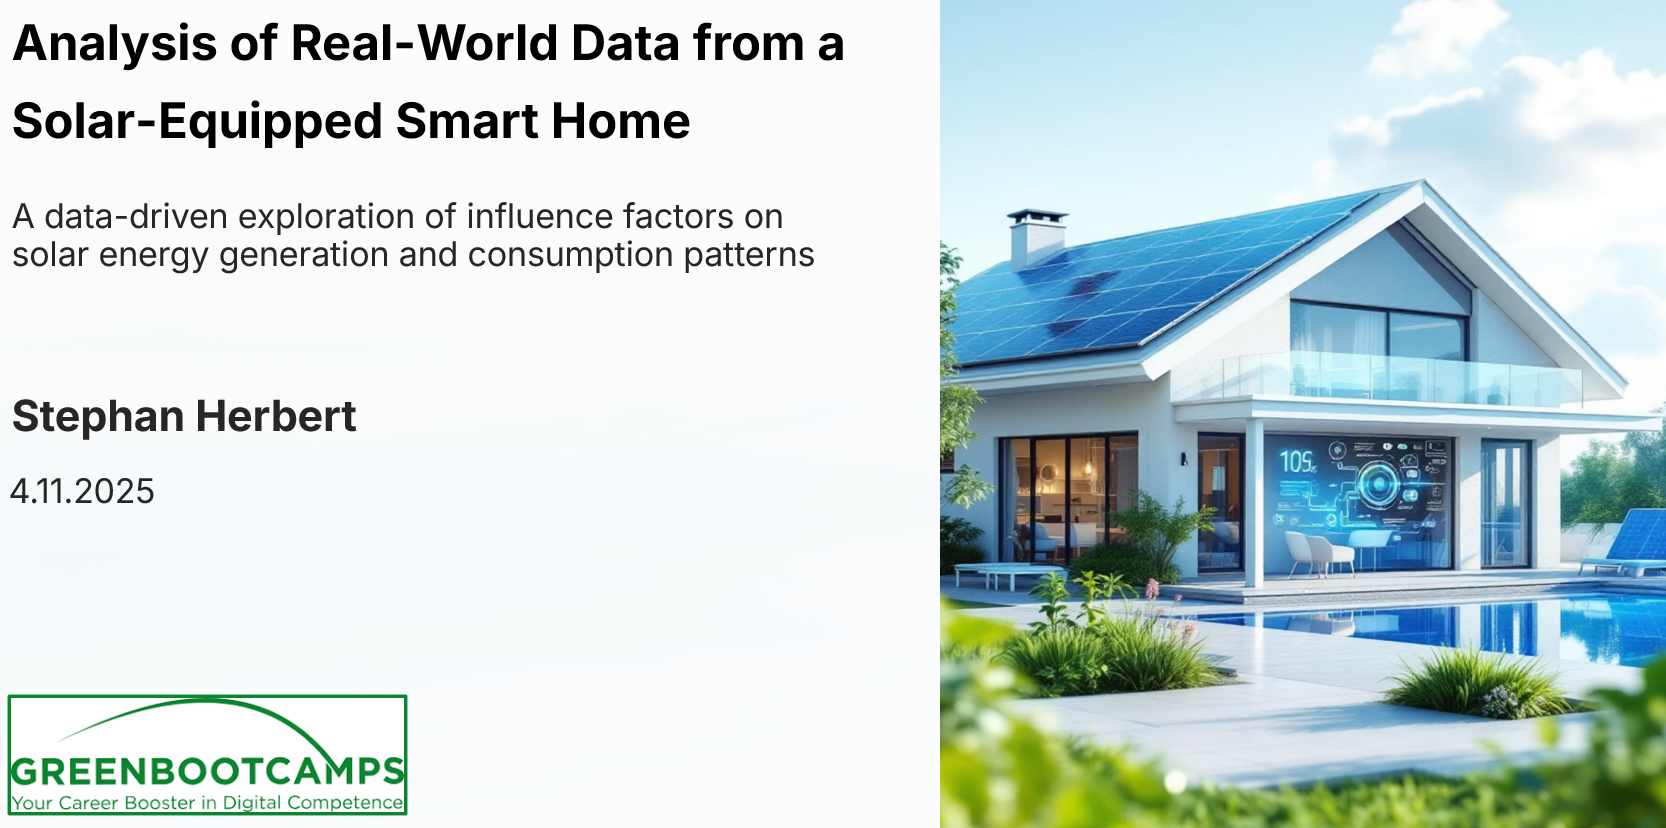

## Overview:
- ``Data source``: 
    - CSV-files  smart home system from my friend "Jürgen"

- ``Main target / tasks ()``:
    - Analyze energy + heating KPI's and give advises for stakeholder for savings

- ``Hypotheses``:
    1. Heating Usage: Heating is used even when outdoor temperature exceeds 15°C
    2. Solar energy: Season/month has greater impact on PV generation than weather conditions
    3. Energy Independence: Self-sufficiency is only achieved in Q2 and Q3
    4. Payback Period: Even under best conditions, the system amortization time can only be reduced by 1 year    compared to current conditions
    
    
    
    

## Main results:
- ``Hypothesis``: 
    1. Heating optimization offers limited savings
    2. Seasonal > weather influences on solar energy
    3. Self-sufficiency achievable in all seasons
    4. Amortization time highly driven by import costs
    
    
- ``Stakeholder recommendations``: 
    1. Monitor heating patterns during spring / fall
    2. Implement data validation checks [NaN values]
    3. Evaluate electricity contracts regularly to reduce yearly costs for import
    

## 1. Install packages

In [1]:
# pip install nbformat

In [2]:
# pip install waterfallcharts

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from pathlib import Path
import re

## 2. Hypotheses + Stakeholder needs:


``Hypotheses - overall:`` <br>
1.......). <br> <br>

``My stakeholder:   Jennifer Montgomery`` <br>
He.....



## 3. Load data + data cleaning

In [4]:
# Read all CSV-files from folder "A_Energy"
data_folder = Path("data/A_Energy")
dfs = [pd.read_csv(file) for file in data_folder.glob("*.csv")]
combined_df = pd.concat(dfs, ignore_index=True)

In [5]:
combined_df.head()

,time,kWh.mean_value
0,2024-03-01T00:00:00.000+01:00,NaN
1,2024-03-01T00:10:00.000+01:00,NaN
2,2024-03-01T00:20:00.000+01:00,NaN
3,2024-03-01T00:30:00.000+01:00,NaN
4,2024-03-01T00:40:00.000+01:00,NaN


### Load different energy tables (solar, import, export...) from folder: 

In [6]:
# === Configuration ===
DATA_DIR = Path("data/A_Energy")         # folder with CSV files
RESAMPLE_RULE = None            # e.g. "1T" for 1-minute grid, or None to skip
LOCAL_TZ = "Europe/Berlin"      # only used if you convert from UTC later

def load_one_csv(path: Path) -> pd.Series:
    """Load one CSV -> return a time-indexed Series named after the file (without extension)."""
    # Read only the necessary columns for speed and clarity
    df = pd.read_csv(path, usecols=["time", "kWh.mean_value"])

    # Parse timestamps; utc=True silences mixed-timezone warnings and standardizes to UTC
    ts = pd.to_datetime(df["time"], errors="coerce", utc=True)

    # Build numeric Series with timestamp index
    s = pd.Series(pd.to_numeric(df["kWh.mean_value"], errors="coerce").values,
                  index=ts, name=path.stem)

    # Drop unparsable timestamps, sort, and aggregate duplicate timestamps (mean)
    s = s[~s.index.isna()].sort_index()
    if s.index.has_duplicates:
        s = s.groupby(level=0).mean()

    return s

def combine_folder(folder: Path, resample_rule: str | None = None) -> pd.DataFrame:
    """Outer-join all Series on their UTC timestamp index; optional resampling to a uniform grid."""
    series_list = []
    for file in sorted(folder.glob("*.csv")):
        try:
            series_list.append(load_one_csv(file))
        except Exception as e:
            print(f"⚠️  Skipping {file.name}: {e}")

    if not series_list:
        raise RuntimeError("No valid CSV files found in the folder.")

    # Outer join on index (timestamps) -> wide table with one column per file
    wide = pd.concat(series_list, axis=1)

    # Optional: resample to a uniform time grid (e.g., "1T", "5T", "1H", "1D")
    if resample_rule:
        wide = wide.resample(resample_rule).mean()

    return wide

# === Run ===
wide_df = combine_folder(DATA_DIR, resample_rule=RESAMPLE_RULE)

print(wide_df.shape)
print(wide_df.head())

# Optional: if you prefer local time for display/plots, convert from UTC:
# wide_df = wide_df.tz_convert(LOCAL_TZ)


(83370, 6)
                           A_PV-Energie_01-data_2024-03_2025-09_total-pv-generation_600s_kWh  \
time                                                                                           
2024-02-29 23:00:00+00:00                                                NaN                   
2024-02-29 23:10:00+00:00                                                NaN                   
2024-02-29 23:20:00+00:00                                                NaN                   
2024-02-29 23:30:00+00:00                                                NaN                   
2024-02-29 23:40:00+00:00                                                NaN                   

                           A_PV-Energie_02-data_2024-03_2025-09_total-consumed-energy_600s_kWh  \
time                                                                                             
2024-02-29 23:00:00+00:00                                                NaN                     
2024-02-29 23:10:00+00

In [7]:
# Shorten column names

def shorten_column_name(col_name):    
    parts = col_name.split("_")     # Split by underscores
    return parts[5]                 # part 5: e.g. total-pv-generation

# Apply to all column names
wide_df.columns = [shorten_column_name(col) for col in wide_df.columns]

# Print result
print(wide_df.columns)


Index(['total-pv-generation', 'total-consumed-energy', 'total-imported-energy',
       'total-exported-energy', 'total-battery-charge',
       'total-battery-discharge'],
      dtype='object')


In [8]:
# Create date column from index column
wide_df["date"] = wide_df.index.date

wide_df.tail()



,total-pv-generation,total-consumed-energy,total-imported-energy,total-exported-energy,total-battery-charge,total-battery-discharge,date
time,,,,,,,
2025-09-30 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.3,2025-09-30
2025-09-30 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.4,2025-09-30
2025-09-30 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.5,2025-09-30
2025-09-30 21:40:00+00:00,NaN,NaN,2543.3,NaN,NaN,NaN,2025-09-30
2025-09-30 21:50:00+00:00,NaN,NaN,2543.4,NaN,NaN,NaN,2025-09-30


### Prepare data for aggregation (-> Daily max-value instead of running total)

In [9]:
import pandas as pd
import numpy as np

def subtract_prev_day_max(df, date_col="date"):
    """
    Subtracts the previous day's maximum value from each numeric column.
    This is useful for cumulative energy data where each new day should
    continue from zero relative to the previous day's end.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing at least one numeric column and a date column.
    date_col : str, default 'date'
        Column name containing the calendar date (e.g. '2024-02-29').

    Returns
    -------
    pandas.DataFrame
        Copy of the original DataFrame where numeric values are adjusted
        so that the previous day's maximum is subtracted from each day's values.
    """

    df = df.copy()

    # Ensure date column exists
    if date_col not in df.columns:
        raise ValueError(f"'{date_col}' column not found in DataFrame.")

    # Select numeric columns
    num_cols = df.select_dtypes(include="number").columns

    # Compute daily max per column
    daily_max = df.groupby(date_col)[num_cols].max()

    # Shift by one day → get the previous day's maximums
    prev_day_max = daily_max.shift(1)

    # Subtract previous day's max from each numeric column
    for col in num_cols:
        df[col] = df[col] - df[date_col].map(prev_day_max[col].to_dict())

    # Replace negative values (e.g., first day) with 0
    df[num_cols] = df[num_cols].clip(lower=0)

    return df


In [10]:
# Create new dataframe
wide_df_daily0 = subtract_prev_day_max(wide_df, date_col="date")

# Shorten column names (without "total-")
wide_df_daily0.columns = [col.replace( "total-", "") for col in wide_df_daily0.columns]



# Create date / year columns from index column
wide_df_daily0["date"] = wide_df_daily0.index.date
wide_df_daily0["month"] = wide_df_daily0.index.month
wide_df_daily0["quarter"] = wide_df_daily0.index.quarter
wide_df_daily0["year"] = wide_df_daily0.index.year
wide_df_daily0["year_quarter"] = wide_df_daily0.index.to_period("Q").astype(str).str.replace("Q", "_Q")   # Quarter -> to 2024_Q1

# Example output (max per day):
wide_df_daily0.groupby('date').max().isna().sum()

C:\Users\steph\AppData\Local\Temp\ipykernel_37920\2125492433.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  wide_df_daily0["year_quarter"] = wide_df_daily0.index.to_period("Q").astype(str).str.replace("Q", "_Q")   # Quarter -> to 2024_Q1


pv-generation         10
consumed-energy        6
imported-energy      239
exported-energy       87
battery-charge        12
battery-discharge     49
month                  0
quarter                0
year                   0
year_quarter           0
dtype: int64

In [11]:
wide_df_daily0


,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,date,month,quarter,year,year_quarter
time,,,,,,,,,,,
2024-02-29 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,4.5,2025-09-30,9,3,2025,2025_Q3
2025-09-30 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,4.6,2025-09-30,9,3,2025,2025_Q3
2025-09-30 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,4.7,2025-09-30,9,3,2025,2025_Q3


In [12]:
values_per_day = wide_df_daily0.groupby('date').max().round(2)

values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter
date,,,,,,,,,,
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2024,2024_Q1
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1
2024-03-03,21.6,10.0,NaN,12.3,6.4,6.8,3,1,2024,2024_Q1
2024-03-04,3.5,9.0,NaN,0.2,1.6,4.0,3,1,2024,2024_Q1


In [13]:
# Convert index to "data time"
values_per_day.index = pd.to_datetime(values_per_day.index)

values_per_day["date"] = values_per_day.index.date

values_per_day.head(2)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2024,2024_Q1,2024-02-29
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1,2024-03-01


In [14]:
values_per_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 580 entries, 2024-02-29 to 2025-09-30
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pv-generation      570 non-null    float64
 1   consumed-energy    574 non-null    float64
 2   imported-energy    341 non-null    float64
 3   exported-energy    493 non-null    float64
 4   battery-charge     568 non-null    float64
 5   battery-discharge  531 non-null    float64
 6   month              580 non-null    int32  
 7   quarter            580 non-null    int32  
 8   year               580 non-null    int32  
 9   year_quarter       580 non-null    object 
 10  date               580 non-null    object 
dtypes: float64(6), int32(3), object(2)
memory usage: 47.6+ KB


In [15]:
# Delete 1st row (only contains NaN-values)
values_per_day = values_per_day.drop(pd.Timestamp("2024-02-29"))
values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1,2024-03-01
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02
2024-03-03,21.6,10.0,NaN,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03
2024-03-04,3.5,9.0,NaN,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05


### Fill all NaN with 0


In [16]:
# Fill all NaN with 0
values_per_day = values_per_day.fillna(0)

values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05


In [17]:
values_per_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 579 entries, 2024-03-01 to 2025-09-30
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pv-generation      579 non-null    float64
 1   consumed-energy    579 non-null    float64
 2   imported-energy    579 non-null    float64
 3   exported-energy    579 non-null    float64
 4   battery-charge     579 non-null    float64
 5   battery-discharge  579 non-null    float64
 6   month              579 non-null    int32  
 7   quarter            579 non-null    int32  
 8   year               579 non-null    int32  
 9   year_quarter       579 non-null    object 
 10  date               579 non-null    object 
dtypes: float64(6), int32(3), object(2)
memory usage: 47.5+ KB


### Financial calculations
- Price "Imported energy":   0.40 € per kWh  --> loss
- Price "Exported energy":   0.082 € per kWh --> win for stakeholder ("Einspeisevergütung")

In [18]:
# Import costs (0.40 € per kWh)    (Import = NaN --> result = 0)
values_per_day["costs_import_loss"] = values_per_day["imported-energy"].fillna(0) * 0.40

# Export win (0.082 € per kWh)
values_per_day["costs_export_win"] = values_per_day["exported-energy"].fillna(0) * 0.082

# Former costs without solar panels: Consumed-Energy * 0.40 €/kWH
values_per_day["costs_consumed_without_PV"] = values_per_day["consumed-energy"].fillna(0) * 0.40

values_per_day.head()

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date,costs_import_loss,costs_export_win,costs_consumed_without_PV
date,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01,0.00,0.0000,0.0
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02,1.20,0.2378,2.8
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03,0.00,1.0086,4.0
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04,0.00,0.0164,3.6
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05,3.12,0.0082,4.0


In [19]:
# Flag-column: if "imported-energy" = NaN -> 1, else 0
# values_per_day["day_import"] = np.where(values_per_day['imported-energy'] > 0, "Import", "No import")

# Categorize import values into three groups
values_per_day["day_import"] = np.select(
    [
        values_per_day['imported-energy'].between(0, 1, inclusive="neither"),  # between 0 and 1
        values_per_day['imported-energy'] > 1                                  # greater than 1
    ],
    [
        "Import < 1 kWh",   # first condition
        "Import"            # second condition
    ],
    default="No import"      # everything else (<= 0)
)


# Flag-column: if "battery-discharge" > "charge" -> 1, else 0
values_per_day["day_battery"] = np.where(values_per_day["battery-discharge"] > values_per_day["battery-charge"],  "Discharging", "Charging")

values_per_day

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date,costs_import_loss,costs_export_win,costs_consumed_without_PV,day_import,day_battery
date,,,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01,0.00,0.0000,0.0,No import,Discharging
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02,1.20,0.2378,2.8,Import,Charging
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03,0.00,1.0086,4.0,No import,Discharging
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04,0.00,0.0164,3.6,No import,Discharging
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05,3.12,0.0082,4.0,Import,Charging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-26,10.6,7.0,2.1,2.8,5.3,2.8,9,3,2025,2025_Q3,2025-09-26,0.84,0.2296,2.8,Import,Charging
2025-09-27,9.3,12.0,0.8,0.6,6.5,8.0,9,3,2025,2025_Q3,2025-09-27,0.32,0.0492,4.8,Import < 1 kWh,Discharging
2025-09-28,11.8,8.0,2.0,2.9,6.2,3.7,9,3,2025,2025_Q3,2025-09-28,0.80,0.2378,3.2,Import,Charging


In [20]:
values_per_day.columns

Index(['pv-generation', 'consumed-energy', 'imported-energy',
       'exported-energy', 'battery-charge', 'battery-discharge', 'month',
       'quarter', 'year', 'year_quarter', 'date', 'costs_import_loss',
       'costs_export_win', 'costs_consumed_without_PV', 'day_import',
       'day_battery'],
      dtype='object')

In [21]:

# Change order of columns (for waterfall diagram)
values_per_day = values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy", 
                                  "date", "month", "quarter", "year", "year_quarter",
                                  'costs_import_loss', 'costs_export_win', 'costs_consumed_without_PV', 
                                  'day_import', 'day_battery']]

values_per_day.head()

,pv-generation,consumed-energy,battery-charge,battery-discharge,imported-energy,exported-energy,date,month,quarter,year,year_quarter,costs_import_loss,costs_export_win,costs_consumed_without_PV,day_import,day_battery
date,,,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,6.6,0.0,0.0,2024-03-01,3,1,2024,2024_Q1,0.00,0.0000,0.0,No import,Discharging
2024-03-02,11.8,7.0,6.9,2.3,3.0,2.9,2024-03-02,3,1,2024,2024_Q1,1.20,0.2378,2.8,Import,Charging
2024-03-03,21.6,10.0,6.4,6.8,0.0,12.3,2024-03-03,3,1,2024,2024_Q1,0.00,1.0086,4.0,No import,Discharging
2024-03-04,3.5,9.0,1.6,4.0,0.0,0.2,2024-03-04,3,1,2024,2024_Q1,0.00,0.0164,3.6,No import,Discharging
2024-03-05,2.7,10.0,1.1,0.6,7.8,0.1,2024-03-05,3,1,2024,2024_Q1,3.12,0.0082,4.0,Import,Charging


In [22]:
# Export daily values to CSV
values_per_day.to_csv("export-file.csv", index=True)

## 4.) Outlier check

In [40]:
house_weather.columns

Index(['date', 'pv-generation', 'temperature_2m_max', 'temperature_2m_mean',
       'temperature_2m_min', 'precipitation_sum', 'precipitation_hours',
       'daylight_duration', 'cloudcover_mean', 'wind_speed_10m_max',
       'weathercode_text', 'sunshine_hours', 'daylight_hours',
       'precip_category', 'weather_type', 'is_dry_day', 'weather_type_num'],
      dtype='object')

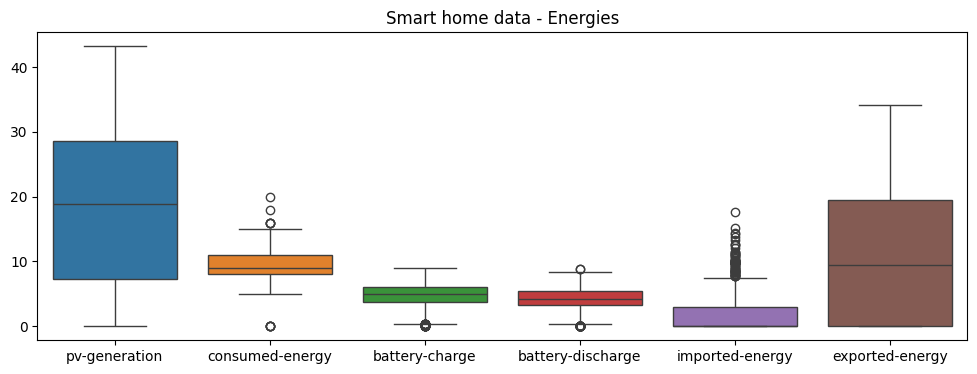

In [41]:
# Boxplot <=> Outliers   - Smart home data
plt.figure(figsize=(12,4))
sns.boxplot(values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy" ]])
# plt.ylim(60,74)
plt.title("Smart home data - Energies")
plt.show()

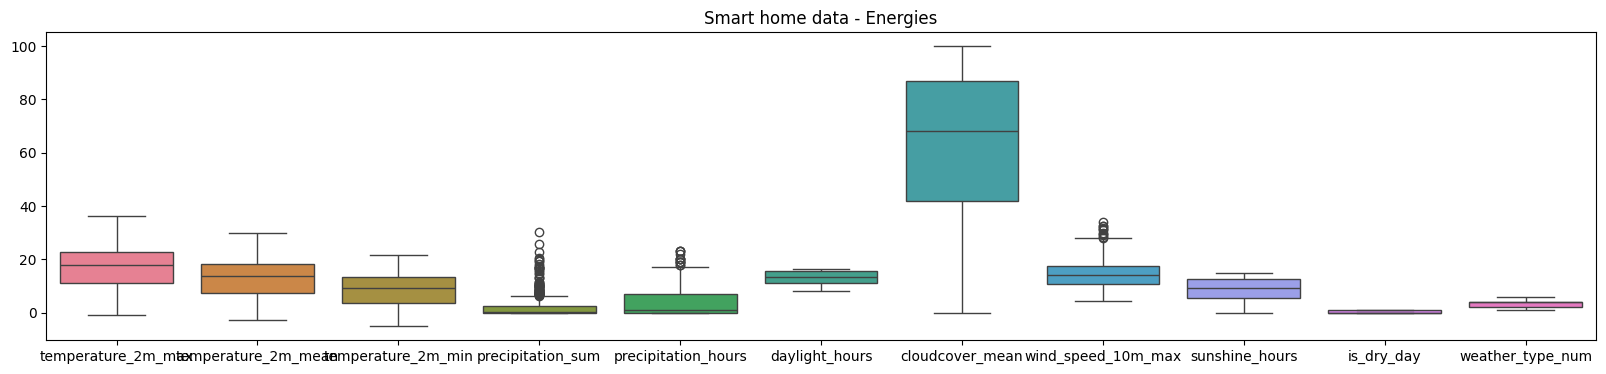

In [42]:
# Boxplot <=> Outliers   - Weather data
plt.figure(figsize=(20,4))
sns.boxplot(house_weather[['temperature_2m_max', 'temperature_2m_mean',
       'temperature_2m_min', 'precipitation_sum', 'precipitation_hours',
       'daylight_hours', 'cloudcover_mean', 'wind_speed_10m_max',
       'weathercode_text', 'sunshine_hours', 'precip_category', 'weather_type',
       'is_dry_day', 'weather_type_num' ]])
# plt.ylim(60,74)
plt.title("Smart home data - Energies")
plt.show()

## 5.) Correlations: Energy + weather data

### Merge weather data <=> smart home data + cleaning

- Source: Open Meteo API
- File used for download:  "Open_meteo_Eschborn_daily_ETL_classifikation.py"
- Infos about data: https://open-meteo.com/en/docs#weathervariables

In [23]:
weather = pd.read_csv("data/Weather/eschborn_daily_weather_20240301-20250930.csv")

weather.head()

,date,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day
0,2024-03-01,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True
1,2024-03-02,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True
2,2024-03-03,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True
3,2024-03-04,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True
4,2024-03-05,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False


In [24]:
weather["date"] = pd.to_datetime(weather["date"])  

weather.head()

,date,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day
0,2024-03-01,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True
1,2024-03-02,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True
2,2024-03-03,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True
3,2024-03-04,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True
4,2024-03-05,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False


In [25]:
# Translate "weather_type" (string) into numbers 1 - 6

# Define mapping dictionary
weather_mapping = {
    'sunny': 1,
    'partly_cloudy': 2,
    'cloudy': 3,
    'drizzle': 4,
    'rainy': 5,
    'snow': 6
}

# Apply the mapping
weather['weather_type_num'] = weather['weather_type'].map(weather_mapping)

weather.head()

,date,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num
0,2024-03-01,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True,3
1,2024-03-02,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True,3
2,2024-03-03,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True,2
3,2024-03-04,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True,3
4,2024-03-05,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False,4


In [26]:
pv_gen = values_per_day[["pv-generation"]]
pv_gen.head(2)

,pv-generation
date,
2024-03-01,0.0
2024-03-02,11.8


In [27]:
# Merge house data <=> weather data
house_weather = pv_gen.merge(weather, how="inner", on="date")

house_weather.head()

,date,pv-generation,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num
0,2024-03-01,0.0,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True,3
1,2024-03-02,11.8,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True,3
2,2024-03-03,21.6,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True,2
3,2024-03-04,3.5,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True,3
4,2024-03-05,2.7,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False,4


In [28]:
# Drop columns that are useless for correlation:
house_weather = house_weather.drop(["sunshine_duration", "weathercode"], 
                                    axis = 1)

### Correlation matrix

#### 1.) All columns from "values per day" + weather

In [29]:
# All columns from 
house_weather_ALL = values_per_day.drop('date', axis = 1).merge(weather, how="inner", on="date")

house_weather_ALL

,date,pv-generation,consumed-energy,battery-charge,battery-discharge,imported-energy,exported-energy,month,quarter,year,...,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num
0,2024-03-01,0.0,0.0,0.0,6.6,0.0,0.0,3,1,2024,...,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True,3
1,2024-03-02,11.8,7.0,6.9,2.3,3.0,2.9,3,1,2024,...,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True,3
2,2024-03-03,21.6,10.0,6.4,6.8,0.0,12.3,3,1,2024,...,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True,2
3,2024-03-04,3.5,9.0,1.6,4.0,0.0,0.2,3,1,2024,...,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True,3
4,2024-03-05,2.7,10.0,1.1,0.6,7.8,0.1,3,1,2024,...,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,2025-09-26,10.6,7.0,5.3,2.8,2.1,2.8,9,3,2025,...,92,13.0,55,"Niesel, stark",5.665000,11.945131,moderate,drizzle,False,4
575,2025-09-27,9.3,12.0,6.5,8.0,0.8,0.6,9,3,2025,...,70,7.6,51,"Niesel, leicht",7.492092,11.883139,light,drizzle,False,4
576,2025-09-28,11.8,8.0,6.2,3.7,2.0,2.9,9,3,2025,...,45,8.1,51,"Niesel, leicht",8.345397,11.820953,light,drizzle,False,4
577,2025-09-29,11.8,11.0,6.4,8.3,0.2,2.9,9,3,2025,...,58,7.4,51,"Niesel, leicht",10.527550,11.758611,light,drizzle,False,4


In [30]:
# Correlation matrix for merged data set
corr_matrix_ALL = house_weather_ALL.corr(numeric_only=True)

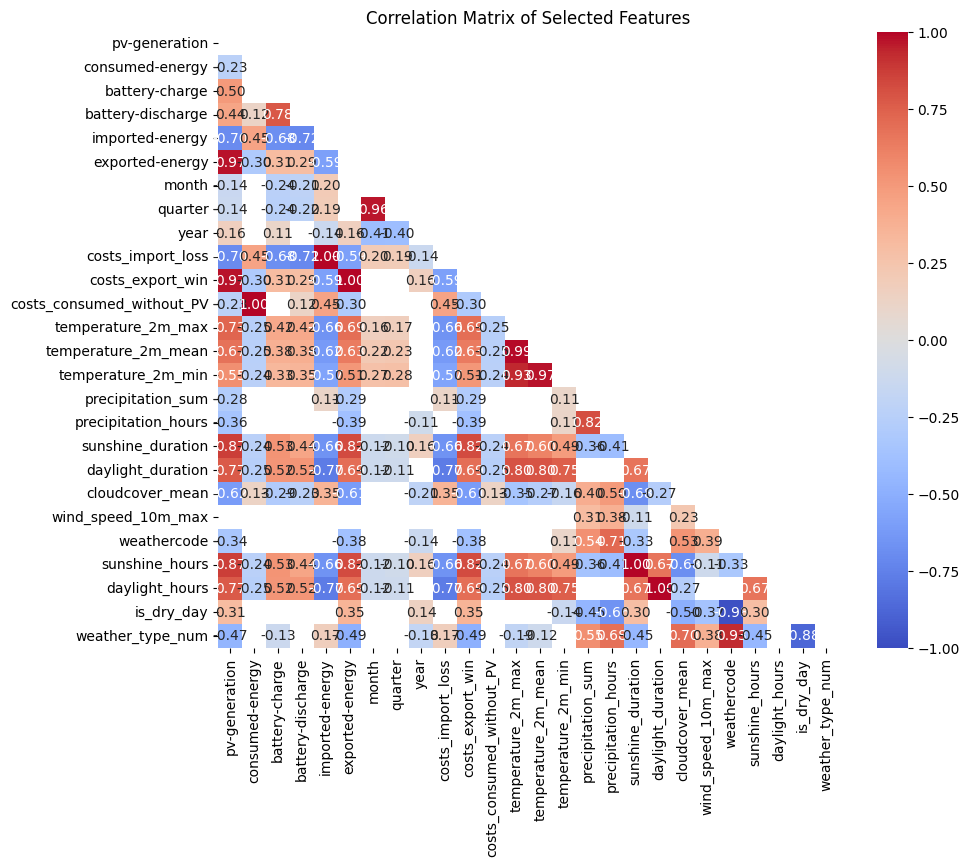

In [31]:
# Combined mask (no upper triangle + no "weak" correlations)
mask_upper_all = np.triu(np.ones_like(corr_matrix_ALL, dtype=bool))       # Mask 1: hide upper triagle of matrix
mask_weak_all = (corr_matrix_ALL > -0.1) & (corr_matrix_ALL < 0.1)          # Mask 2: hide weak correlations
mask = mask_upper_all  | mask_weak_all                                      # Combined mask

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_ALL, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.show()


#### 2.) Only interesting columns (PV-generation + weather_best-correlations)

In [32]:
# Correlation matrix for merged data set
corr_matrix = house_weather.corr(numeric_only=True)

In [33]:
# Get correlation values of all columns with the target column "pv-generation"
target = "pv-generation"
corr_with_target = corr_matrix[target].sort_values(ascending=False).round(2)

# threshold-based filtering
interesting_corr = corr_with_target[abs(corr_with_target) > 0.3]

print(interesting_corr)
# print(corr_with_target)

pv-generation          1.00
sunshine_hours         0.87
daylight_duration      0.77
daylight_hours         0.77
temperature_2m_max     0.73
temperature_2m_mean    0.67
temperature_2m_min     0.55
is_dry_day             0.31
precipitation_hours   -0.36
weather_type_num      -0.47
cloudcover_mean       -0.62
Name: pv-generation, dtype: float64


In [34]:
# List with interesting columns
interesting_cols = interesting_corr.index.tolist()
    # print("Columns most correlated with pv-generation:", interesting_cols)

# Filtered dataframe for correlations:
filtered_corr = corr_matrix.loc[interesting_cols, interesting_cols]
filtered_corr

,pv-generation,sunshine_hours,daylight_duration,daylight_hours,temperature_2m_max,temperature_2m_mean,temperature_2m_min,is_dry_day,precipitation_hours,weather_type_num,cloudcover_mean
pv-generation,1.000000,0.868029,0.770428,0.770428,0.733193,0.673530,0.550820,0.311083,-0.358740,-0.466265,-0.616781
sunshine_hours,0.868029,1.000000,0.668010,0.668010,0.667242,0.602392,0.486671,0.296032,-0.406798,-0.449195,-0.684915
daylight_duration,0.770428,0.668010,1.000000,1.000000,0.798502,0.796774,0.750688,-0.067269,0.048891,-0.080902,-0.269166
daylight_hours,0.770428,0.668010,1.000000,1.000000,0.798502,0.796774,0.750688,-0.067269,0.048891,-0.080902,-0.269166
temperature_2m_max,0.733193,0.667242,0.798502,0.798502,1.000000,0.986880,0.934807,0.029691,-0.067563,-0.193109,-0.346214
temperature_2m_mean,0.673530,0.602392,0.796774,0.796774,0.986880,1.000000,0.974272,-0.042430,0.006717,-0.116412,-0.273190
temperature_2m_min,0.550820,0.486671,0.750688,0.750688,0.934807,0.974272,1.000000,-0.140769,0.112829,-0.007952,-0.163839
is_dry_day,0.311083,0.296032,-0.067269,-0.067269,0.029691,-0.042430,-0.140769,1.000000,-0.662396,-0.879110,-0.501263
precipitation_hours,-0.358740,-0.406798,0.048891,0.048891,-0.067563,0.006717,0.112829,-0.662396,1.000000,0.680749,0.499481
weather_type_num,-0.466265,-0.449195,-0.080902,-0.080902,-0.193109,-0.116412,-0.007952,-0.879110,0.680749,1.000000,0.701436


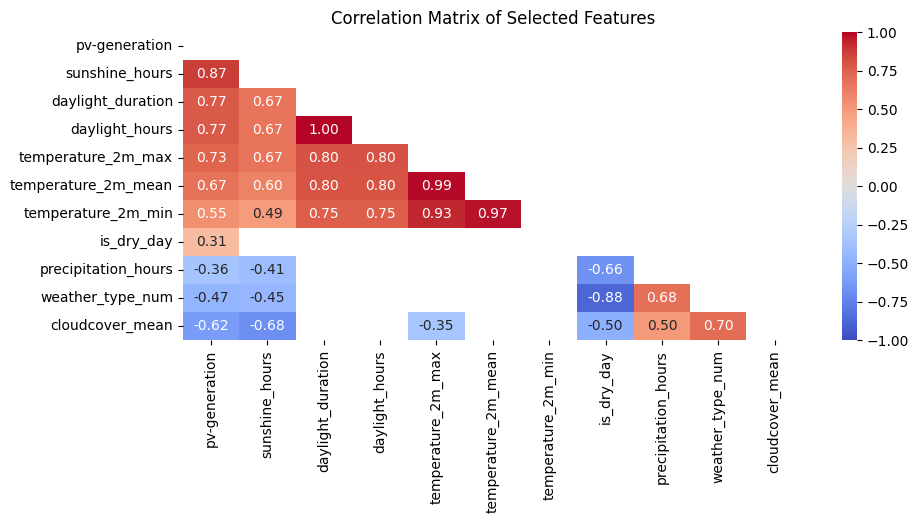

In [35]:
# Combined mask (no upper triangle + no "weak" correlations)
mask_upper = np.triu(np.ones_like(filtered_corr, dtype=bool))       # Mask 1: hide upper triagle of matrix
mask_weak = (filtered_corr > -0.3) & (filtered_corr < 0.3)          # Mask 2: hide weak correlations
mask = mask_upper  | mask_weak                                      # Combined mask

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.show()


#### 3.) Only PV-generation + sunshine + daylight

In [36]:
only_pv_sun = house_weather[['pv-generation', 'sunshine_hours', 'daylight_duration']]

only_pv_sun = only_pv_sun.rename(columns={
                                    'pv-generation': 'solar_kWh',
                                    'sunshine_hours': 'sunshine_h',
                                    'daylight_duration': 'daylight_h'})

corr_matrix_pv_sun = only_pv_sun.corr(numeric_only=True)

corr_matrix_pv_sun

,solar_kWh,sunshine_h,daylight_h
solar_kWh,1.000000,0.868029,0.770428
sunshine_h,0.868029,1.000000,0.668010
daylight_h,0.770428,0.668010,1.000000


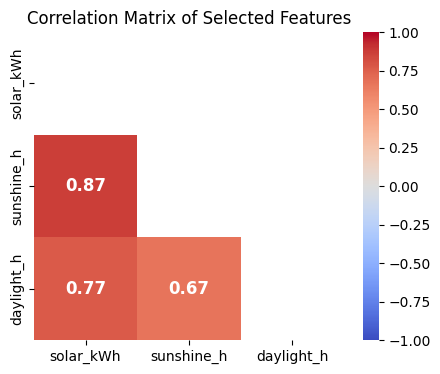

In [37]:
# Combined mask (no upper triangle + no "weak" correlations)
mask = np.triu(np.ones_like(corr_matrix_pv_sun, dtype=bool))       # Mask: hide upper triagle of matrix


# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix_pv_sun, cmap='coolwarm', mask=mask, 
             vmin=-1, vmax=1,
             annot=True, fmt=".2f",  annot_kws={"size": 12, "weight": "bold"})  #  annotations
plt.title('Correlation Matrix of Selected Features')
plt.show()


#### 3.) Only PV-generation + weather type (sunny -> cloud / rain) + Cloudcover (mean % per day)

In [38]:
only_pv_weather = house_weather[['pv-generation', 'weather_type_num', 'cloudcover_mean']]

only_pv_weather = only_pv_weather.rename(columns={
                                    'pv-generation': 'solar_kWh',
                                    'weather_type_num': 'weather_type',
                                    'cloudcover_mean': 'cloudcover_%'})

corr_matrix_pv_weather = only_pv_weather.corr(numeric_only=True)

corr_matrix_pv_weather

,solar_kWh,weather_type,cloudcover_%
solar_kWh,1.000000,-0.466265,-0.616781
weather_type,-0.466265,1.000000,0.701436
cloudcover_%,-0.616781,0.701436,1.000000


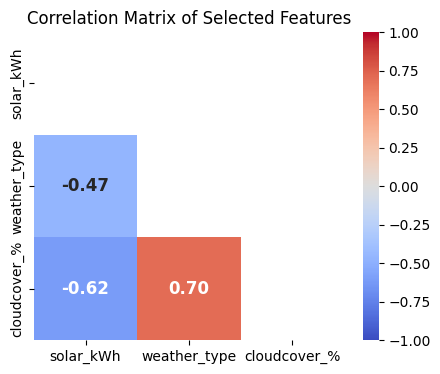

In [39]:
# Combined mask (no upper triangle + no "weak" correlations)
mask = np.triu(np.ones_like(corr_matrix_pv_weather, dtype=bool))       # Mask: hide upper triagle of matrix


# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix_pv_weather, cmap='coolwarm', mask=mask, 
             vmin=-1, vmax=1,
             annot=True, fmt=".2f",  annot_kws={"size": 12, "weight": "bold"})  #  annotations
plt.title('Correlation Matrix of Selected Features')
plt.show()


## 6.) Autarky - Self-sufficiency
Autarkie [%] = (1 - (Import + Batterieverluste) / Verbrauch)


In [43]:
# self-sufficiency per row
autarky_per_row = (1 - 
        (values_per_day["imported-energy"] 
            + values_per_day["battery-charge"] 
            - values_per_day["battery-discharge"])
        / values_per_day["consumed-energy"])
autarky_per_row.head()

date
2024-03-01         inf
2024-03-02   -0.085714
2024-03-03    1.040000
2024-03-04    1.266667
2024-03-05    0.170000
dtype: float64

In [44]:
#  Function to calculate "Autarky" = self_sufficiency

def calc_self_sufficiency_sum(df_slice: pd.DataFrame) -> float:
    """
    Calculate total self-sufficiency ratio for a given time slice,
    using aggregated sums across the entire period.
    Formula:
        1 - ((Σ imported + Σ charge - Σ discharge) / Σ consumed)
    """
    # Compute aggregated sums for each energy type
    imported_sum = df_slice["imported-energy"].sum(skipna=True)
    charge_sum = df_slice["battery-charge"].sum(skipna=True)
    discharge_sum = df_slice["battery-discharge"].sum(skipna=True)
    consumed_sum = df_slice["consumed-energy"].sum(skipna=True)
    
    # Avoid division by zero
    if consumed_sum == 0:
        return np.nan
    
    # Apply the formula using aggregated totals
    result = 1 - ((imported_sum + charge_sum - discharge_sum) / consumed_sum)
    return result.round(2)


In [45]:
# Define time windows (in days)
windows = {
    "last_7d": 7,
    "last_30d": 30,
    "last_365d": 365,
}

results = {}

# Ensure index is datetime
values_per_day.index = pd.to_datetime(values_per_day.index)

# Loop through all windows
for name, days in windows.items():
    # Define time range
    end_date = values_per_day.index.max()  # use latest available date in data
    start_date = end_date - pd.Timedelta(days=days)
    
    # Filter by date range using .loc
    df_win = values_per_day.loc[start_date:end_date]
    
    # Compute total self-sufficiency for that period
    results[name] = calc_self_sufficiency_sum(df_win)

print(results)


{'last_7d': np.float64(0.66), 'last_30d': np.float64(0.82), 'last_365d': np.float64(0.62)}


# 7.) Heating evaluation

In [59]:
df_heating = pd.read_csv("data/C_Heating/C_Heizung-Energie_01-data_2024-03_2025-09_heating-gas-consumption-current-day_600s_m3.csv")

df_heating

,time,m³.mean_value
0,2024-03-01T00:00:00.000+01:00,NaN
1,2024-03-01T00:10:00.000+01:00,NaN
2,2024-03-01T00:20:00.000+01:00,NaN
3,2024-03-01T00:30:00.000+01:00,0.1
4,2024-03-01T00:40:00.000+01:00,NaN
...,...,...
83365,2025-09-30T23:10:00.000+02:00,3.6
83366,2025-09-30T23:20:00.000+02:00,NaN
83367,2025-09-30T23:30:00.000+02:00,NaN
83368,2025-09-30T23:40:00.000+02:00,NaN


In [60]:
# Create date column for aggregation
df_heating["time"] = pd.to_datetime(df_heating["time"], errors="coerce", utc=True)
df_heating["date"] = pd.to_datetime(df_heating["time"]).dt.date
df_heating

,time,m³.mean_value,date
0,2024-02-29 23:00:00+00:00,NaN,2024-02-29
1,2024-02-29 23:10:00+00:00,NaN,2024-02-29
2,2024-02-29 23:20:00+00:00,NaN,2024-02-29
3,2024-02-29 23:30:00+00:00,0.1,2024-02-29
4,2024-02-29 23:40:00+00:00,NaN,2024-02-29
...,...,...,...
83365,2025-09-30 21:10:00+00:00,3.6,2025-09-30
83366,2025-09-30 21:20:00+00:00,NaN,2025-09-30
83367,2025-09-30 21:30:00+00:00,NaN,2025-09-30
83368,2025-09-30 21:40:00+00:00,NaN,2025-09-30


In [61]:
# Heating values per day (max value)
heating_per_day = df_heating.groupby('date').max().round(2)
heating_per_day.drop(columns=['time'], inplace=True)

heating_per_day.rename(columns={'m³.mean_value': 'heating-water_m3'}, inplace=True)

heating_per_day.head()

,heating-water_m3
date,
2024-02-29,0.1
2024-03-01,8.9
2024-03-02,7.8
2024-03-03,7.2
2024-03-04,6.5


In [62]:
# Convert index to "date time"
heating_per_day.index = pd.to_datetime(heating_per_day.index)
print(heating_per_day.index.dtype)

datetime64[ns]


In [63]:
# Merge heating data <=> weather data
heating_weather = heating_per_day.merge(weather, how="inner", on="date")

heating_weather.head()

,date,heating-water_m3,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,wind_speed_10m_max,weathercode,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num
0,2024-03-01,8.9,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,15.3,3,bedeckt,4.415114,10.996844,none,cloudy,True,3
1,2024-03-02,7.8,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,9.4,3,bedeckt,7.093011,11.059786,none,cloudy,True,3
2,2024-03-03,7.2,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,12.2,3,bedeckt,9.664825,11.122864,none,partly_cloudy,True,2
3,2024-03-04,6.5,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,18.8,3,bedeckt,0.821819,11.186028,none,cloudy,True,3
4,2024-03-05,6.9,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,9.5,53,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False,4


In [64]:
# Condition columns for Temp_min >= 10°C and Temp_mean >= 15°C
heating_weather['temp_min_above_10']    = heating_weather['temperature_2m_min'] > 10
heating_weather['temp_mean_above_15']   = heating_weather['temperature_2m_mean'] > 15
heating_weather['heating_used']         = heating_weather['heating-water_m3'] > 0.1  

heating_weather.head()

,date,heating-water_m3,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,...,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num,temp_min_above_10,temp_mean_above_15,heating_used
0,2024-03-01,8.9,9.8,4.8,0.2,0.0,0.0,15894.41,39588.64,79,...,bedeckt,4.415114,10.996844,none,cloudy,True,3,False,False,True
1,2024-03-02,7.8,12.3,7.2,4.2,0.0,0.0,25534.84,39815.23,80,...,bedeckt,7.093011,11.059786,none,cloudy,True,3,False,False,True
2,2024-03-03,7.2,14.9,8.3,3.0,0.0,0.0,34793.37,40042.31,66,...,bedeckt,9.664825,11.122864,none,partly_cloudy,True,2,False,False,True
3,2024-03-04,6.5,10.4,7.7,5.5,0.0,0.0,2958.55,40269.70,90,...,bedeckt,0.821819,11.186028,none,cloudy,True,3,False,False,True
4,2024-03-05,6.9,8.6,6.3,2.7,1.6,9.0,0.00,40497.24,83,...,"Niesel, mäßig",0.000000,11.249233,light,drizzle,False,4,False,False,True


In [65]:
# Conditions: Heating <=> Temp_min > 10°C and/or Temp_mean > 15°C

heating_temp_min_higher = ( heating_weather['temp_min_above_10']    &   heating_weather['heating_used']).sum() 
heating_temp_mean_higher = ( heating_weather['temp_mean_above_15']    &   heating_weather['heating_used']).sum() 
heating_temp_min_mean_higher = (heating_weather['temp_min_above_10']    &  heating_weather['temp_mean_above_15']    &   heating_weather['heating_used']).sum() 

print(f'Overall days                  = {heating_weather.date.count()}')
print(f'Heating + Temp_min > 10 °C    = {heating_temp_min_higher}')
print(f'Heating + Temp_mean > 15 °C    = {heating_temp_mean_higher}')
print(f'Heating + Temp_mean + Temp_min = {heating_temp_mean_higher}')

Overall days                  = 579
Heating + Temp_min > 10 °C    = 111
Heating + Temp_mean > 15 °C    = 91
Heating + Temp_mean + Temp_min = 91


In [66]:
# Condition_10_15: Heating <=> Temp_min > 10°C AND Temp_mean > 15°C

condition_10_15 = ((heating_weather['temp_min_above_10'])
    & (heating_weather['temp_mean_above_15'])
    & (heating_weather['heating_used'])
)

heating_and_warm_10_15 = heating_weather[condition_10_15]
count_10_15 = condition_10_15.sum()

print(count_10_15)
heating_and_warm_10_15

78


,date,heating-water_m3,temperature_2m_max,temperature_2m_mean,temperature_2m_min,precipitation_sum,precipitation_hours,sunshine_duration,daylight_duration,cloudcover_mean,...,weathercode_text,sunshine_hours,daylight_hours,precip_category,weather_type,is_dry_day,weather_type_num,temp_min_above_10,temp_mean_above_15,heating_used
36,2024-04-06,3.8,22.9,16.6,11.0,2.0,2.0,43941.33,47730.20,91,...,"Regen, leicht",12.205925,13.258389,moderate,rainy,False,5,True,True,True
37,2024-04-07,3.0,21.8,17.3,11.7,0.0,0.0,36130.73,47953.51,95,...,bedeckt,10.036314,13.320419,none,cloudy,True,3,True,True,True
38,2024-04-08,2.6,23.4,17.9,11.3,0.0,0.0,44375.49,48176.86,61,...,bedeckt,12.326525,13.382461,none,partly_cloudy,True,2,True,True,True
61,2024-05-01,1.9,24.4,19.0,14.3,0.0,0.0,44341.48,53072.85,64,...,bedeckt,12.317078,14.742458,none,partly_cloudy,True,2,True,True,True
62,2024-05-02,2.0,22.6,16.6,13.2,14.5,6.0,43006.74,53272.65,70,...,"Regen, mäßig",11.946317,14.797958,heavy,rainy,False,5,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,2025-09-14,0.3,18.9,15.1,11.4,6.4,9.0,36000.00,45678.91,85,...,"Regen, leicht",10.000000,12.688586,moderate,rainy,False,5,True,True,True
566,2025-09-18,0.2,24.1,17.3,12.2,0.0,0.0,40436.95,44780.69,10,...,bedeckt,11.232486,12.439081,none,sunny,True,1,True,True,True
567,2025-09-19,2.9,25.3,18.5,12.4,0.0,0.0,39948.79,44556.71,14,...,bedeckt,11.096886,12.376864,none,sunny,True,1,True,True,True
568,2025-09-20,2.5,27.3,19.2,12.0,0.0,0.0,40000.59,44333.20,47,...,bedeckt,11.111275,12.314778,none,partly_cloudy,True,2,True,True,True


In [67]:
heating_m3_overall =    heating_weather['heating-water_m3'].sum()
heating_m3_warm =       heating_and_warm_10_15['heating-water_m3'].sum()

print(f'Overall heating m3 = {heating_m3_overall:.2f} m³')
print(f'Heating m3 on warm days = {heating_m3_warm:.2f} m³  --> {(heating_m3_warm / heating_m3_overall * 100):.2f} % of total')

Overall heating m3 = 2181.15 m³
Heating m3 on warm days = 106.90 m³  --> 4.90 % of total


In [68]:
# Condition_10: Heating <=> Temp_min > 10°C

condition_10 = ((heating_weather['temp_min_above_10']) & (heating_weather['heating_used']))

heating_and_warm_10 = heating_weather[condition_10]
count_10 = condition_10.sum()

print(f'The condition "Heating ON" + MIN-Temperature > 10 as true for {count_10} days.')


# Condition_15: Heating <=>  Temp_mean > 15°C

condition_15 = ((heating_weather['temp_mean_above_15']) & (heating_weather['heating_used']))

heating_and_warm_15 = heating_weather[condition_15]
count_15 = condition_15.sum()

print(f'The condition "Heating ON" + MEAN-Temperature > 15 as true for {count_15} days.')

The condition "Heating ON" + MIN-Temperature > 10 as true for 111 days.
The condition "Heating ON" + MEAN-Temperature > 15 as true for 91 days.


# X) OLD-----------------

In [46]:
#---------------ZEILENWEISE-------------- Function to calculate "Autarky" = self_sufficiency
# -------------------------


def calc_self_sufficiency(df_slice: pd.DataFrame) -> float:
    """
    Calculate the self-sufficiency ratio for a given time slice.
    Formula:
        1 - ((imported_energy + battery_charge - battery_discharge) / consumed_energy)
    The result represents how much of the consumed energy is covered without import.
    """
    # Compute the numerator (imported + charged - discharged)
    num = (
        df_slice["imported-energy"]
        + df_slice["battery-charge"]
        - df_slice["battery-discharge"]
    )
    
    # Denominator: total consumed energy
    den = df_slice["consumed-energy"]
    
    # Calculate the self-sufficiency value per row
    result = (1 - (num / den)).replace([np.inf, -np.inf], np.nan)
    
    # Return the mean value over the selected time window (ignore NaNs)
    return result.mean(skipna=True).round(2)


In [47]:
# Define your time windows
windows = {
    "last_7d":      7,
    "last_30d":     30,
    "last_365d":    365,
}

# Create a dictionary to store results
results = {}

# Loop through each time window and calculate the metric
for name, days in windows.items():

    # Select data for the last X days (requires a DateTimeIndex)
    end_date = values_per_day.index.max()
    start_date = end_date - pd.Timedelta(days=days)
    df_win = values_per_day.loc[start_date:end_date]

    print(df_win)
    
    # Compute self-sufficiency for that period
    results[name] = calc_self_sufficiency(df_win)

# Display results as dictionary
print(results)



            pv-generation  consumed-energy  battery-charge  battery-discharge  \
date                                                                            
2025-09-23           17.6             7.00             5.2                3.1   
2025-09-24            1.9            11.33             0.9                2.7   
2025-09-25            3.9             8.67             2.2                1.6   
2025-09-26           10.6             7.00             5.3                2.8   
2025-09-27            9.3            12.00             6.5                8.0   
2025-09-28           11.8             8.00             6.2                3.7   
2025-09-29           11.8            11.00             6.4                8.3   
2025-09-30           10.7            11.00             6.0                4.7   

            imported-energy  exported-energy        date  month  quarter  \
date                                                                       
2025-09-23             2.00          

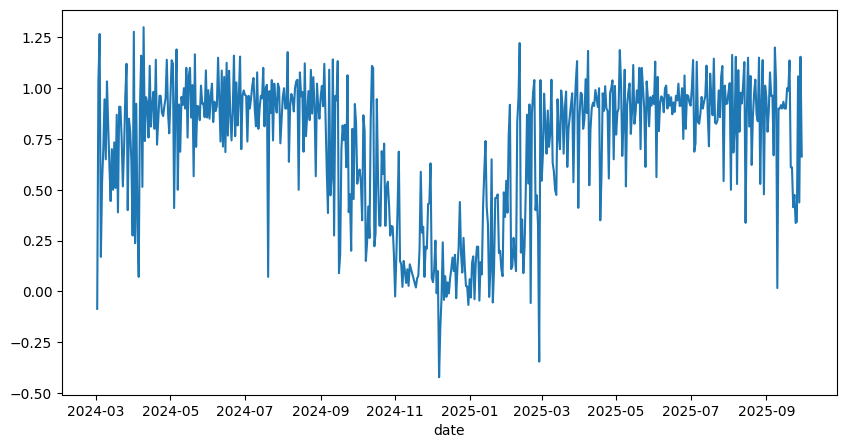

In [48]:
plt.figure(figsize=(10,5))
sns.lineplot(data=autarky_per_row)
plt.show()

In [49]:
values_per_day.isna().sum()

pv-generation                0
consumed-energy              0
battery-charge               0
battery-discharge            0
imported-energy              0
exported-energy              0
date                         0
month                        0
quarter                      0
year                         0
year_quarter                 0
costs_import_loss            0
costs_export_win             0
costs_consumed_without_PV    0
day_import                   0
day_battery                  0
dtype: int64

In [50]:
# Sum of all day max-values
values_overall = values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy" ]].sum()
values_overall

pv-generation        10749.80
consumed-energy       5418.00
battery-charge        2650.75
battery-discharge     2337.90
imported-energy       1273.25
exported-energy       6311.10
dtype: float64

In [51]:
# Negative energy flows:  Multiply "-1" to three columns since these energy are leaving the system
for col in ["consumed-energy", "exported-energy", "battery-charge"]:
    values_overall[col] *= -1

values_overall

pv-generation        10749.80
consumed-energy      -5418.00
battery-charge       -2650.75
battery-discharge     2337.90
imported-energy       1273.25
exported-energy      -6311.10
dtype: float64

In [52]:
import plotly.graph_objects as go

# 1) Labels & Werte flach machen
labels = list(values_overall.index) + ["Net result"]        # -> 7 Labels (6 + total)
y      = values_overall.astype(float).tolist() + [0.0]      # -> 7 Werte (letzter 0 für total)

# 2) measure genau so lang wie x/y
measure = ["relative"] * len(values_overall) + ["total"]    # -> 7 Einträge



# 3) (Optional) Text für die Anzeige
text = [f"{v:+.0f}" for v in values_overall] + [""]         # letzte (total) berechnet Plotly

# # 4) NaNs vermeiden (falls vorhanden)
# y = [0.0 if (isinstance(v, float) and np.isnan(v)) else v for v in y]


fig = go.Figure(go.Waterfall(
    name="Profit Bridge",
    orientation="v",
    measure=["relative", "relative", "relative", "relative", "relative", "relative", "total"],
    x=labels,
    y=y,
    text=[str(v) for v in y],            # show the values as strings
    textposition="outside",
    texttemplate="%{y:.0f}",
    connector={"line":{"width":1}}
))
fig.update_layout(title="Waterfall (Plotly)", yaxis_title="€")
fig.show()


C:\Users\steph\AppData\Local\Temp\ipykernel_37920\3449930793.py:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



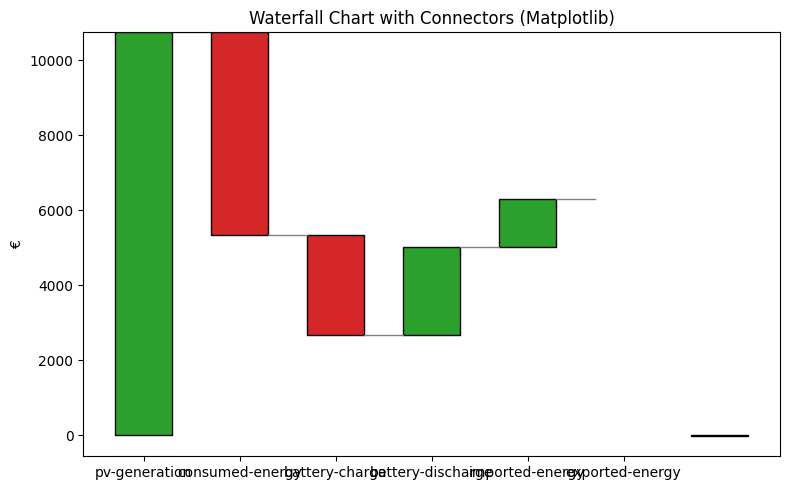

In [53]:
import matplotlib.pyplot as plt
import numpy as np

labels = values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy" ]].columns
values = values_overall

cum = np.cumsum(values)
base = np.hstack(([0], cum[:-1]))  # starting heights
colors = ["tab:green" if v > 0 else "tab:red" for v in values]

fig, ax = plt.subplots(figsize=(8,5))
for i, (label, v, b, c) in enumerate(zip(labels[:-1], values, base, colors)):
    ax.bar(i, v, bottom=b, color=c, edgecolor='black', width=0.6)
    # connector line to next bar
    ax.plot([i+0.3, i+0.7], [b+v, b+v], color='gray', lw=1)

# add total bar
ax.bar(len(values), cum[-1], color='lightgray', edgecolor='black', width=0.6)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("€")
ax.set_title("Waterfall Chart with Connectors (Matplotlib)")
plt.tight_layout()
plt.show()


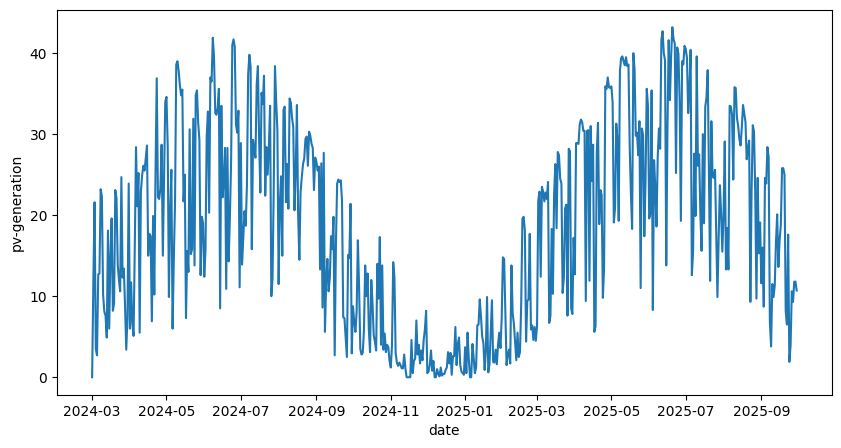

In [54]:
plt.figure(figsize=(10,5))
sns.lineplot(data=values_per_day, x='date', y='pv-generation')
plt.show()

In [55]:
wide_df_daily0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83370 entries, 2024-02-29 23:00:00+00:00 to 2025-09-30 21:50:00+00:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pv-generation      29508 non-null  float64
 1   consumed-energy    14817 non-null  float64
 2   imported-energy    10793 non-null  float64
 3   exported-energy    15352 non-null  float64
 4   battery-charge     11175 non-null  float64
 5   battery-discharge  21087 non-null  float64
 6   date               83370 non-null  object 
 7   month              83370 non-null  int32  
 8   quarter            83370 non-null  int32  
 9   year               83370 non-null  int32  
 10  year_quarter       83370 non-null  object 
dtypes: float64(6), int32(3), object(2)
memory usage: 6.7+ MB


In [56]:
# # 1. Remove rows that are completely empty
# wide_df = wide_df.dropna(how="all")

# # 2. Resample to fixed 10-minute intervals
# wide_df = wide_df.resample("10min").mean()

# # 3. Interpolate small gaps linearly
# wide_df = wide_df.interpolate(limit=6)      #  fill gaps up to 1 hour (6×10min)

# # 4. Optional: forward-fill for long outages
# wide_df = wide_df.ffill(limit=12)           # fill up to 2 hours


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# from pathlib import Path
# import pandas as pd
# from typing import Dict, Optional

# # === Configuration ===
# FREQ = "10min"              # expected grid (10-minute sampling)
# MIN_GAP_LEN = 1           # minimum consecutive NaNs to count as a gap (in steps of FREQ)
# EXPORT_DIR = Path("gap_reports")  # where to save CSV exports (set to None to skip)
# EXPORT_DIR.mkdir(exist_ok=True)

# def ensure_uniform_grid(df: pd.DataFrame, freq: str) -> pd.DataFrame:
#     """Ensure a uniform DateTimeIndex at the given freq. Keeps existing values; introduces NaN where missing."""
#     if not isinstance(df.index, pd.DatetimeIndex):
#         raise TypeError("DataFrame index must be a DateTimeIndex.")
#     df = df.sort_index()
#     full_index = pd.date_range(df.index.min(), df.index.max(), freq=freq, tz=df.index.tz)
#     return df.reindex(full_index)

# def gaps_for_series(s: pd.Series, freq: str, min_gap_len: int = 1) -> pd.DataFrame:
#     """Return a table of gaps (consecutive NaNs) for a single series."""
#     s = s.sort_index()
#     na = s.isna()

#     if na.sum() == 0:
#         return pd.DataFrame(columns=["start", "end", "length_steps", "duration_minutes"])

#     # Identify runs of consecutive NaNs
#     grp = (na != na.shift()).cumsum()
#     runs = na.groupby(grp).agg(["first", "size"])
#     runs = runs[runs["first"] == True].rename(columns={"size": "length_steps"})  # only NaN runs

#     # Filter by minimum gap length
#     runs = runs[runs["length_steps"] >= min_gap_len]
#     if runs.empty:
#         return pd.DataFrame(columns=["start", "end", "length_steps", "duration_minutes"])

#     # Map group labels to start/end timestamps
#     idx = s.index
#     out_rows = []
#     for g, row in runs.iterrows():
#         mask = grp == g
#         # start = first idx where mask True; end = last idx where mask True
#         start = idx[mask].min()
#         end = idx[mask].max()
#         duration_min = row["length_steps"] * pd.to_timedelta(freq).total_seconds() / 60.0
#         out_rows.append({"start": start, "end": end, "length_steps": int(row["length_steps"]),
#                          "duration_minutes": duration_min})

#     gaps_df = pd.DataFrame(out_rows).sort_values("start").reset_index(drop=True)
#     return gaps_df

# def coverage_summary(df: pd.DataFrame, freq: str, min_gap_len: int = 1) -> pd.DataFrame:
#     """Build a per-column summary with coverage, missing minutes, number of gaps, and longest gap."""
#     total_steps = len(df.index)
#     minutes_per_step = pd.to_timedelta(freq).total_seconds() / 60.0
#     rows = []
#     for col in df.columns:
#         s = df[col]
#         gaps_df = gaps_for_series(s, freq, min_gap_len)
#         total_missing_steps = s.isna().sum()
#         total_missing_minutes = total_missing_steps * minutes_per_step
#         longest_gap = gaps_df["duration_minutes"].max() if not gaps_df.empty else 0.0
#         coverage = 1.0 - (total_missing_steps / total_steps if total_steps > 0 else 0.0)
#         rows.append({
#             "sensor": col,
#             "steps_total": total_steps,
#             "steps_missing": int(total_missing_steps),
#             "minutes_missing": total_missing_minutes,
#             "gaps_count": len(gaps_df),
#             "longest_gap_minutes": longest_gap,
#             "coverage_pct": coverage * 100.0
#         })
#     return pd.DataFrame(rows).sort_values("coverage_pct", ascending=False).reset_index(drop=True)

# def build_gap_reports(wide_df: pd.DataFrame,
#                       freq: str = FREQ,
#                       min_gap_len: int = MIN_GAP_LEN,
#                       export_dir: Optional[Path] = EXPORT_DIR) -> Dict[str, pd.DataFrame]:
#     """
#     Create:
#       - uniform grid at `freq`
#       - per-column gap tables
#       - overall summary
#       - (optional) CSV exports
#     Returns a dict with {"uniform_df", "summary", "gaps": {column: df}}.
#     """
#     # 1) Make sure we are on a uniform time grid
#     uniform = ensure_uniform_grid(wide_df, freq=freq)

#     # 2) Per-series gap tables
#     gaps_dict: Dict[str, pd.DataFrame] = {}
#     for col in uniform.columns:
#         gaps_df = gaps_for_series(uniform[col], freq=freq, min_gap_len=min_gap_len)
#         gaps_dict[col] = gaps_df
#         if export_dir:
#             (export_dir / f"gaps_{col}.csv").write_text(gaps_df.to_csv(index=False), encoding="utf-8")

#     # 3) Summary
#     summary = coverage_summary(uniform, freq=freq, min_gap_len=min_gap_len)
#     if export_dir:
#         (export_dir / "gap_summary.csv").write_text(summary.to_csv(index=False), encoding="utf-8")

#     return {"uniform_df": uniform, "summary": summary, "gaps": gaps_dict}

# # === Example usage (assuming you already built `wide_df` from your CSVs and it is UTC DatetimeIndex) ===
# reports = build_gap_reports(wide_df, freq=FREQ, min_gap_len=1, export_dir=EXPORT_DIR)

# # Quick peek:
# print(reports["summary"].head())
# # To inspect gaps of a specific sensor/column:
# # reports["gaps"]["A_PV-Energie_01-data_2024-03_2025-09_total-pv-generation_600s_kWh"].head()
# print(reports["summary"])

                    sensor  steps_total  steps_missing  minutes_missing  \
0                     date        83370              0              0.0   
1      total-pv-generation        83370          53792         537920.0   
2  total-battery-discharge        83370          62093         620930.0   
3    total-exported-energy        83370          67835         678350.0   
4    total-consumed-energy        83370          68538         685380.0   

   gaps_count  longest_gap_minutes  coverage_pct  
0           0                  0.0    100.000000  
1        4514               6420.0     35.477990  
2       12488               9890.0     25.521171  
3        2020               8500.0     18.633801  
4        6254               6440.0     17.790572  
                    sensor  steps_total  steps_missing  minutes_missing  \
0                     date        83370              0              0.0   
1      total-pv-generation        83370          53792         537920.0   
2  total-battery-d

In [ ]:
# print(reports["summary"])


                    sensor  steps_total  steps_missing  minutes_missing  \
0                     date        83370              0              0.0   
1      total-pv-generation        83370          53792         537920.0   
2  total-battery-discharge        83370          62093         620930.0   
3    total-exported-energy        83370          67835         678350.0   
4    total-consumed-energy        83370          68538         685380.0   
5     total-battery-charge        83370          72159         721590.0   
6    total-imported-energy        83370          72212         722120.0   

   gaps_count  longest_gap_minutes  coverage_pct  
0           0                  0.0    100.000000  
1        4514               6420.0     35.477990  
2       12488               9890.0     25.521171  
3        2020               8500.0     18.633801  
4        6254               6440.0     17.790572  
5        2236               6470.0     13.447283  
6        5673              11400.0     13.

In [ ]:
# # Remove all row that show "NaN" in ALL value columns

# wide_df = wide_df.dropna(how="all")
# wide_df.shape

(83370, 7)

In [ ]:
# wide_df.columns

Index(['total-pv-generation', 'total-consumed-energy', 'total-imported-energy',
       'total-exported-energy', 'total-battery-charge',
       'total-battery-discharge', 'date'],
      dtype='object')

In [ ]:
# parts = wide_df.columns.split("_") 

AttributeError: 'Index' object has no attribute 'split'

wide_df.

In [ ]:


# # === Konfiguration ===
# DATA_DIR = Path("data/A_Energy")         # Ordner mit CSV-Dateien
# PATTERN_TS = re.compile(r"^(time|timestamp|date|datetime|zeit|zeitstempel)$", re.I)
# # Fallback: nehme die erste Datetime-parsebare Spalte
# # Wertspalte: erste numerische Spalte, die nicht TS ist

# READ_KW = dict(
#     sep=",",           # anpassen: ";" falls nötig
#     decimal=".",       # anpassen: "," falls nötig
#     engine="python",
# )

# # Optional: auf ein Raster bringen (z.B. 1 Minute)
# RESAMPLE_RULE = None  # z.B. "1T" für 1-Minuten-Raster; oder None lassen


# def guess_columns(df: pd.DataFrame):
#     # 1) Zeitstempelspalte finden
#     ts_col = None
#     for c in df.columns:
#         if PATTERN_TS.match(str(c).strip()):
#             ts_col = c
#             break
#     if ts_col is None:
#         # Fallback: erste Spalte, die sich stabil in Datetime parsen lässt
#         for c in df.columns:
#             try:
#                 pd.to_datetime(df[c], errors="raise")
#                 ts_col = c
#                 break
#             except Exception:
#                 continue
#     if ts_col is None:
#         raise ValueError("Keine Zeitstempelspalte gefunden.")

#     # 2) Wertspalte finden (erste numerische, die nicht ts_col ist)
#     value_col = None
#     non_ts_cols = [c for c in df.columns if c != ts_col]
#     # versuche numerisch zu erzwingen
#     for c in non_ts_cols:
#         s = pd.to_numeric(df[c], errors="coerce")
#         # mind. paar nicht-NaNs => numerisch
#         if s.notna().sum() > 0:
#             value_col = c
#             break
#     if value_col is None:
#         # letzter Fallback: nimm die erste Nicht-TS-Spalte
#         if non_ts_cols:
#             value_col = non_ts_cols[0]
#         else:
#             raise ValueError("Keine Wertspalte gefunden.")

#     return ts_col, value_col


# def load_one_csv(path: Path) -> pd.Series:
#     df = pd.read_csv(path, **READ_KW)
#     ts_col, val_col = guess_columns(df)

#     # Datetime parsen (mit dayfirst=True falls EU-Formate; bei Bedarf ändern)
#     ts = pd.to_datetime(df[ts_col], errors="coerce", dayfirst=True, utc=False)

#     # Index setzen & bereinigen
#     s = pd.Series(pd.to_numeric(df[val_col], errors="coerce").values, index=ts, name=path.stem)
#     s = s[~s.index.isna()]                # drop unparsbare Zeitstempel
#     s = s.sort_index()

#     # Duplikate auf gleicher Zeitmarke aggregieren (z.B. Mittelwert)
#     if s.index.has_duplicates:
#         s = s.groupby(level=0).mean()

#     return s


# def combine_folder(folder: Path, resample_rule: str | None = None) -> pd.DataFrame:
#     series_list = []
#     for file in sorted(folder.glob("*.csv")):
#         try:
#             series_list.append(load_one_csv(file))
#         except Exception as e:
#             print(f"⚠️  Überspringe {file.name}: {e}")

#     if not series_list:
#         raise RuntimeError("Keine gültigen CSVs gefunden.")

#     wide = pd.concat(series_list, axis=1)  # outer-join per Index (Zeit)

#     # Optional: auf ein einheitliches Zeitraster bringen
#     if resample_rule:
#         wide = wide.resample(resample_rule).mean()

#     return wide


# wide_df = combine_folder(DATA_DIR, resample_rule=RESAMPLE_RULE)

# print(wide_df.shape)
# print(wide_df.head())

C:\Users\steph\AppData\Local\Temp\ipykernel_22132\734793239.py:61: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  ts = pd.to_datetime(df[ts_col], errors="coerce", dayfirst=True, utc=False)
C:\Users\steph\AppData\Local\Temp\ipykernel_22132\734793239.py:61: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  ts = pd.to_datetime(df[ts_col], errors="coerce", dayfirst=True, utc=False)
C:\Users\steph\AppData\Local\Temp\ipykernel_22132\734793239.py:61: Futur

(32688, 6)
                           A_PV-Energie_01-data_2024-03_2025-09_total-pv-generation_600s_kWh  \
time                                                                                           
2024-01-03 00:00:00+01:00                                                NaN                   
2024-01-03 00:10:00+01:00                                                NaN                   
2024-01-03 00:20:00+01:00                                                NaN                   
2024-01-03 00:30:00+01:00                                                NaN                   
2024-01-03 00:40:00+01:00                                                NaN                   

                           A_PV-Energie_02-data_2024-03_2025-09_total-consumed-energy_600s_kWh  \
time                                                                                             
2024-01-03 00:00:00+01:00                                                NaN                     
2024-01-03 00:10:00+01

C:\Users\steph\AppData\Local\Temp\ipykernel_22132\734793239.py:61: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  ts = pd.to_datetime(df[ts_col], errors="coerce", dayfirst=True, utc=False)
